In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

import seaborn as sns


We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [63]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas and see what happens off of this kind of naive approach.

In [65]:

#rfc = ensemble.RandomForestClassifier()
#X = y2015.drop('loan_status', 1)
#Y = y2015['loan_status']
#X = pd.get_dummies(X)

#cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [66]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
12
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [67]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [68]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [70]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,8.49,471.77,64000.0,18.28,0.0,...,0,0,0,0,0,1,0,0,0,0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,12.88,678.49,65000.0,21.77,0.0,...,0,0,0,0,0,1,0,0,0,0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,11.99,400.31,112000.0,8.68,0.0,...,0,0,0,0,0,1,0,0,0,0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,1,0,0,0,0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [71]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)


array([ 0.97926907,  0.98038517,  0.98169124,  0.98190497,  0.97266682,
        0.97831869,  0.96418818,  0.9802655 ,  0.9794571 ,  0.98054909])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

### Feature exploration

First, let's take a look at the relationships among the different features. We can anticipate that features like 'outstanding principal' and 'last payment amount' will be important predictors of loan status, since those features correspond directly to the status of a loan; for example, a paid-off loan has no outstanding principal by definition, and payment of a loan in a grace period has not yet come due by definition. These features will probably need to remain in the model. 

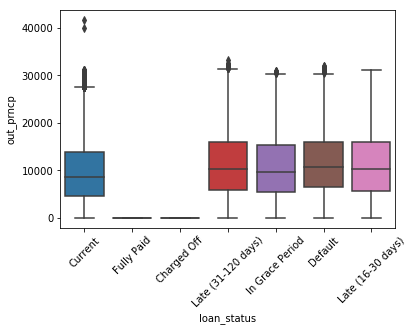

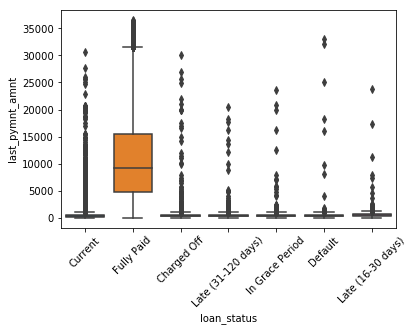

In [72]:
sns.boxplot(y='out_prncp', x='loan_status', data=y2015)
plt.xticks(rotation=45)
plt.show()

sns.boxplot(y='last_pymnt_amnt', x='loan_status', data=y2015)
plt.xticks(rotation=45)
plt.show()

Let's take a quick look at the correlation matrix of this busy feature space.

In [73]:
# Your code here.

corrmat = y2015.corr()
print(corrmat)

                                      id  member_id  loan_amnt  funded_amnt  \
id                              1.000000   0.997540  -0.008288    -0.008288   
member_id                       0.997540   1.000000  -0.008620    -0.008620   
loan_amnt                      -0.008288  -0.008620   1.000000     1.000000   
funded_amnt                    -0.008288  -0.008620   1.000000     1.000000   
funded_amnt_inv                -0.008554  -0.008885   0.999994     0.999994   
int_rate                       -0.053402  -0.053447   0.140572     0.140572   
installment                    -0.012919  -0.013274   0.941205     0.941205   
annual_inc                      0.015055   0.014958   0.305734     0.305734   
dti                             0.005692   0.005806   0.006103     0.006103   
delinq_2yrs                     0.002300   0.002261  -0.010424    -0.010424   
inq_last_6mths                  0.000660   0.000715  -0.039040    -0.039040   
mths_since_last_delinq          0.006322   0.006186 

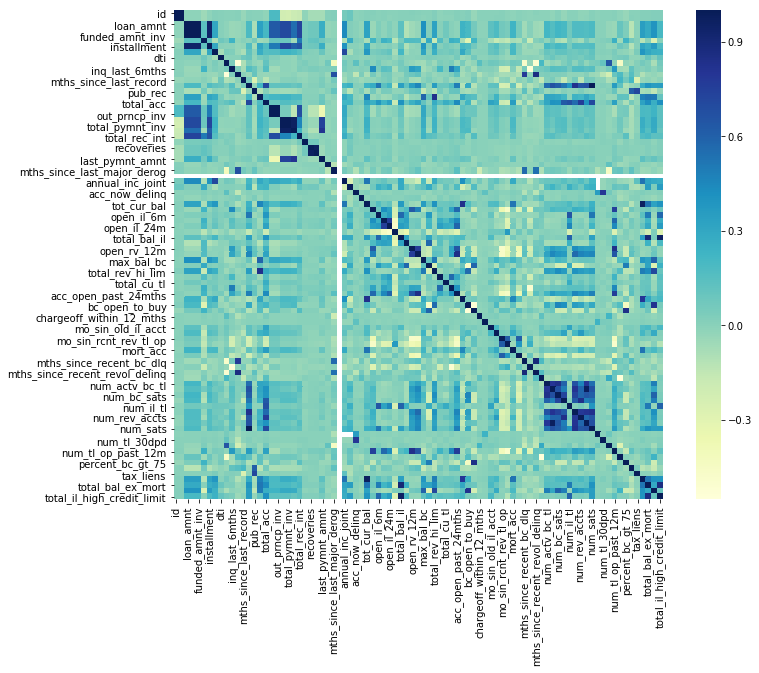

In [74]:
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=1, square=True, cmap="YlGnBu")
plt.show()

Since there are 237 features in the predictor dataset, we can anticipate that several will be highly correlated with one another; however, PCA on such a busy feature space is not particularly helpful, since there is too much noise in the data to identify particularly powerful components. 

Covariance Matrix:
 [[  1.00000237e+00   9.97542503e-01  -8.28800909e-03 ...,   3.16988700e-02
    1.52046554e-02   2.45114833e-02]
 [  9.97542503e-01   1.00000237e+00  -8.61952110e-03 ...,   3.20023212e-02
    1.53795433e-02   2.47610695e-02]
 [ -8.28800909e-03  -8.61952110e-03   1.00000237e+00 ...,   8.35951079e-03
    7.08866573e-03   1.43504240e-02]
 ..., 
 [  3.16988700e-02   3.20023212e-02   8.35951079e-03 ...,   1.00000237e+00
   -3.12145102e-04  -5.16540667e-04]
 [  1.52046554e-02   1.53795433e-02   7.08866573e-03 ...,  -3.12145102e-04
    1.00000237e+00  -2.39751698e-04]
 [  2.45114833e-02   2.47610695e-02   1.43504240e-02 ...,  -5.16540667e-04
   -2.39751698e-04   1.00000237e+00]]
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [  5.37510280e-02   3.08675475e-02   2.98605548e-02   2.36895213e-02
   1.88822300e-02   1.60688620e-02   1.57362748e-02   1.46202636e-02
   1.31328272e-02   1.29376303e-02   1.16481687e-02   1.12247931e-0

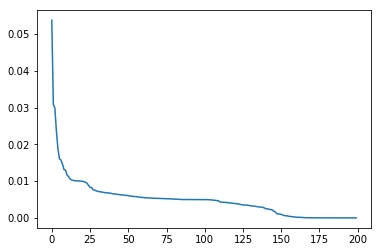

In [75]:
from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


#Normalize the variables.
X_pca = StandardScaler().fit_transform(X)

# Transpose X_pca.
Xt = X_pca.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

#Run PCA analysis on the variables
sklearn_pca = PCA(n_components=200)
Y_sklearn = sklearn_pca.fit_transform(X_pca)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

plt.plot(sklearn_pca.explained_variance_ratio_)
plt.show()

We can reasonably remove a few features, like ID and Member ID, which are unique to each row and are actually categorical. There are also several features that are not very informative, or whose abbreviations are unclear, so let's use the Select K Best feature selection method to reduce the feature space further. 

In [76]:
X = y2015.drop(['loan_status', 'id', 'member_id'], 1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,0.0,11.0,...,0,0,0,0,0,1,0,0,0,0
1,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,0.0,7.0,...,0,0,0,0,0,1,0,0,0,0
2,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,1.0,9.0,...,0,0,0,0,0,1,0,0,0,0
3,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,0.0,16.0,...,0,0,0,0,0,1,0,0,0,0
4,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,4.0,18.0,...,0,0,0,0,0,1,0,0,0,0


In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=30)
fit = test.fit(X, Y)

names = X.columns.values[fit.get_support()]
scores = test.scores_[fit.get_support()]
names_scores = list(zip(names, scores))

ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'chi2_Scores'])

#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['chi2_Scores', 'Feat_names'], ascending = [False, True])

print(ns_df_sorted)

#Fit_transform new X based on 30 best features
X_new = test.fit_transform(X, Y)

                     Feat_names   chi2_Scores
15              last_pymnt_amnt  2.884083e+09
6                     out_prncp  1.177185e+09
7                 out_prncp_inv  1.176667e+09
10              total_rec_prncp  9.387946e+08
8                   total_pymnt  5.875220e+08
9               total_pymnt_inv  5.873330e+08
22              tot_hi_cred_lim  3.111773e+08
13                   recoveries  3.048039e+08
17                  tot_cur_bal  2.536353e+08
14      collection_recovery_fee  5.341486e+07
18             total_rev_hi_lim  4.051699e+07
24               total_bc_limit  4.017345e+07
19                  avg_cur_bal  3.342817e+07
11                total_rec_int  3.303126e+07
4                    annual_inc  3.071302e+07
5                     revol_bal  1.859766e+07
23            total_bal_ex_mort  3.004754e+06
1                   funded_amnt  2.848401e+06
0                     loan_amnt  2.848401e+06
2               funded_amnt_inv  2.838971e+06
25   total_il_high_credit_limit  1

Now using this cleaner set of 30 features, we'll try the ensemble RFC model again, and see if we get more consistent and accurate results. 

In [81]:
#X_new = selector.fit_transform(X, y)

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_new, Y, cv=10)



array([ 0.95820569,  0.96737195,  0.96924794,  0.96855928,  0.96183804,
        0.96606507,  0.96601677,  0.96756038,  0.96432897,  0.96713058])

Now that we've pruned the feature set, the model performs much better than the previous version. We are hovering around 96% accuracy on all 10 folds. 

Note, I also tried using a recursive feature elimination algorithm (code below), but it throws an error. Although the ensemble RFC didn't have an issue with the string values of Y above, when used in the selector, these valeus of Y seem to produce a type error ("could not convert string to float: 'Charged Off'"). Do you have any insight into why this is the case?

In [82]:

from sklearn.feature_selection import RFECV

rfr = ensemble.RandomForestClassifier()

selector = RFECV(estimator=rfr, step=1, cv=5, scoring='r2')
selector = selector.fit(X, Y)
pred = selector.predict(X)
score = selector.score(X, Y)

names = X.columns.values[selector.get_support()]
scores = test.scores_[selector.get_support()]
names_scores = list(zip(names, scores))

ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'r2_Scores'])

#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['r2_Scores', 'Feat_names'], ascending = [False, True])

print(ns_df_sorted)

ValueError: could not convert string to float: 'Charged Off'